In [2]:
#Imports
import sys
import json
import csv
import yaml
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import time
from datetime import datetime
import pprint
import psycopg2
from sqlalchemy import create_engine, text as sql_text

#Import Util
sys.path.append('benchmarking/')
import util

#Load Environment Variables
dotenv_path = 'variables.env'
load_dotenv(dotenv_path=dotenv_path)
schema = os.getenv('DISC_6_SCHEMA')
port = os.getenv('DISC_6_PORT')
host = os.getenv('DISC_6_HOST')
database = os.getenv('DISC_6_DB')
password = os.getenv('DISC_6_PASSWORD')
connection = os.getenv('DISC_6_CONNECTION')

#Create Engine
db_eng = create_engine(f"postgresql+psycopg2://{connection}:{password}@{host}:{port}/{database}",
                       connect_args={'options': '-csearch_path={}'.format(schema)},
                       isolation_level = 'SERIALIZABLE')
print("Successfully created db engine.")

Successfully created db engine.


In [ ]:
##STEP 3A
#D.1.2 Setup for test 1, run once to create new column

qupdate = """
 alter table reviews
     add column datetime timestamp;
"""

qimport = """update reviews
     set datetime = TO_TIMESTAMP((TO_CHAR(date, 'YYYY-MM-DD') || ' 12:00:00'),
                         'YYYY-MM-DD hh24:mi:ss')::timestamp without time zone;"""

with db_eng.connect() as conn:
    result = conn.execute(sql_text(qupdate))
    result = conn.execute(sql_text(qimport))


In [ ]:
# Helper: Initialize the listings_join_reviews json
# Note: If you get an error, you need to add the directory perf_data
util.write_perf_data({}, 'listings_join_reviews.json')

# sanity check
perf_summary = util.fetch_perf_data('listings_join_reviews.json')
pprint.pp(perf_summary, indent=4)

In [3]:
#D.1.4 Run Test 1
all_indexes = [['datetime','reviews'], ['id','listings']]
perf_summary = util.fetch_perf_data('listings_join_reviews.json')

count = 50
# store all of the index combinations to test
specs = [[],[['datetime','reviews']],[['id','listings']],[['datetime','reviews'],['id','listings']]]

for spec in specs: # for all combinations of indices
    
    # set up the correct indices
    print('Processing spec: ', str(spec), '\n')
    for index in all_indexes:
        if index not in spec:
            mod_index = util.add_drop_index(db_eng, 'drop', index[0], index[1])
            print('\nAfter doing the drop for', str(index), 'the indexes on table "' + index[1] + '" are: ')
            print(mod_index)

    for index in spec:
        mod_index = util.add_drop_index(db_eng, 'add', index[0], index[1])
        print('\nAfter doing the add for', str(index), 'the indexes on table "' + index[1] + '" are: ')
        print(mod_index)
    
    for yr in range(2009,2025): # iterate over all years and run queries for each
        start_date = str(yr) + '-01-01'
        end_date = str(yr) + '-12-13'
        query = util.build_query_listings_join_reviews_datetime(start_date, end_date)
        query_name = "q_listings_join_review_" + str(yr)
        
        # run the actual query a bunch of times
        time_list = []
        for i in range(0,count):
            time_start = datetime.now()
            # Open new db connection for each execution of the query to avoid multithreading
            with db_eng.connect() as conn:
                df = pd.read_sql(query, con=conn)
            time_end = datetime.now()
            diff = util.time_diff(time_start, time_end)
            time_list.append(diff)
        
        # get the statistics for this run
        perf_profile = {}
        perf_profile['avg'] = round(sum(time_list)/len(time_list), 4)
        perf_profile['min'] = round(min(time_list), 4)
        perf_profile['max'] = round(max(time_list), 4)
        perf_profile['std'] = round(np.std(time_list), 4)
        perf_profile['count'] = count
        
        perf_profile['timestamp'] = util.get_timestamp()

        print('\nThe list of running times is as follows:')
        pprint.pp(time_list)

        print('\nThe statistics on the list of running times are as follows:')
        pprint.pp(perf_profile)
        
        key_value = util.build_index_description_key(all_indexes, spec)
        print('\nThe new value for"' + key_value + '"will be', str(perf_profile))
        
        if query_name in perf_summary:
            perf_dict = perf_summary[query_name]
            print("\nBefore modifying perf_dict, the value of perf_summary[query_name] (if it existed) was: ")
            pprint.pp(perf_dict)
        else:
            perf_dict = {}
            print("\nBefore modifying perf_dict, the value of perf_summary[query_name] had empty value")
        print()
        perf_dict[key_value] = perf_profile
        perf_summary[query_name] = perf_dict

        print("\nAfter modifying perf_dict, the value of perf_summary[query_name] is: ")
        pprint.pp(perf_summary[query_name])
        print()

        print('\nThe full value of perf_summary is:')
        pprint.pp(perf_summary)


util.write_perf_data(perf_summary, 'listings_join_reviews.json')

Processing spec:  [] 


Index name:datetime_in_reviews
QUERY TO EXECUTE:
BEGIN TRANSACTION;
DROP INDEX IF EXISTS datetime_in_reviews;
 END TRANSACTION;


After doing the drop for ['datetime', 'reviews'] the indexes on table "reviews" are: 
[]

Index name:id_in_listings
QUERY TO EXECUTE:
BEGIN TRANSACTION;
DROP INDEX IF EXISTS id_in_listings;
 END TRANSACTION;


After doing the drop for ['id', 'listings'] the indexes on table "listings" are: 
[]

The list of running times is as follows:
[0.188826,
 0.148269,
 0.145949,
 0.137131,
 0.140788,
 0.146264,
 0.139703,
 0.140072,
 0.146173,
 0.142567,
 0.139308,
 0.135529,
 0.139019,
 0.143724,
 0.143098,
 0.138465,
 0.135893,
 0.136581,
 0.150512,
 0.141847,
 0.140515,
 0.145798,
 0.147786,
 0.144162,
 0.151582,
 0.138653,
 0.143575,
 0.142084,
 0.141162,
 0.141042,
 0.138252,
 0.144503,
 0.137774,
 0.133859,
 0.133911,
 0.133473,
 0.134646,
 0.13377,
 0.134058,
 0.133663,
 0.133859,
 0.136317,
 0.135917,
 0.135509,
 0.135641,
 0.133694,
 0.1


The list of running times is as follows:
[0.134069,
 0.144662,
 0.14286,
 0.141224,
 0.133273,
 0.133042,
 0.134173,
 0.133071,
 0.139309,
 0.136821,
 0.136914,
 0.13595,
 0.141711,
 0.135819,
 0.135144,
 0.141932,
 0.138581,
 0.133007,
 0.137047,
 0.137866,
 0.136438,
 0.135095,
 0.132175,
 0.138854,
 0.142401,
 0.14036,
 0.138332,
 0.138085,
 0.134016,
 0.133908,
 0.141323,
 0.138111,
 0.136099,
 0.133671,
 0.133583,
 0.13323,
 0.137659,
 0.139773,
 0.140306,
 0.13911,
 0.138384,
 0.137691,
 0.140821,
 0.139417,
 0.133984,
 0.133738,
 0.134144,
 0.137275,
 0.142197,
 0.134483]

The statistics on the list of running times are as follows:
{'avg': 0.1372,
 'min': 0.1322,
 'max': 0.1447,
 'std': 0.0032,
 'count': 50,
 'timestamp': '2024-5-18-20:51:38'}

The new value for"__"will be {'avg': 0.1372, 'min': 0.1322, 'max': 0.1447, 'std': 0.0032, 'count': 50, 'timestamp': '2024-5-18-20:51:38'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) was: 
{'__': {'a


The list of running times is as follows:
[0.130623,
 0.134545,
 0.138461,
 0.139357,
 0.137558,
 0.137983,
 0.138329,
 0.135358,
 0.13089,
 0.13271,
 0.140061,
 0.13928,
 0.135356,
 0.154083,
 0.129088,
 0.139768,
 0.143873,
 0.136288,
 0.131403,
 0.130937,
 0.136729,
 0.139566,
 0.139677,
 0.136086,
 0.131816,
 0.131101,
 0.136416,
 0.136559,
 0.133895,
 0.134533,
 0.134291,
 0.138046,
 0.145441,
 0.134148,
 0.133645,
 0.134347,
 0.141911,
 0.137651,
 0.135528,
 0.133299,
 0.13137,
 0.141159,
 0.144495,
 0.137714,
 0.131884,
 0.139522,
 0.140638,
 0.138909,
 0.132655,
 0.138206]

The statistics on the list of running times are as follows:
{'avg': 0.1367,
 'min': 0.1291,
 'max': 0.1541,
 'std': 0.0045,
 'count': 50,
 'timestamp': '2024-5-18-20:51:45'}

The new value for"__"will be {'avg': 0.1367, 'min': 0.1291, 'max': 0.1541, 'std': 0.0045, 'count': 50, 'timestamp': '2024-5-18-20:51:45'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) was: 
{'__': {'


The list of running times is as follows:
[0.138582,
 0.158439,
 0.142342,
 0.138555,
 0.134007,
 0.141846,
 0.132114,
 0.14373,
 0.14236,
 0.138212,
 0.133811,
 0.131356,
 0.132904,
 0.136993,
 0.136334,
 0.133542,
 0.138789,
 0.138633,
 0.144577,
 0.140689,
 0.135659,
 0.140489,
 0.131434,
 0.136681,
 0.14022,
 0.135247,
 0.141032,
 0.140186,
 0.137329,
 0.132564,
 0.139016,
 0.143369,
 0.137322,
 0.132889,
 0.137826,
 0.140058,
 0.137636,
 0.133552,
 0.136017,
 0.142235,
 0.139824,
 0.133856,
 0.136338,
 0.139406,
 0.138883,
 0.134247,
 0.139109,
 0.140356,
 0.139123,
 0.133008]

The statistics on the list of running times are as follows:
{'avg': 0.1381,
 'min': 0.1314,
 'max': 0.1584,
 'std': 0.0045,
 'count': 50,
 'timestamp': '2024-5-18-20:51:51'}

The new value for"__"will be {'avg': 0.1381, 'min': 0.1314, 'max': 0.1584, 'std': 0.0045, 'count': 50, 'timestamp': '2024-5-18-20:51:51'}

Before modifying perf_dict, the value of perf_summary[query_name] had empty value


After modify


The list of running times is as follows:
[0.144947,
 0.14918,
 0.137651,
 0.145926,
 0.146995,
 0.139083,
 0.136463,
 0.13862,
 0.144242,
 0.272851,
 0.140845,
 0.136395,
 0.144284,
 0.146352,
 0.144469,
 0.143903,
 0.143957,
 0.144607,
 0.142503,
 0.142326,
 0.141853,
 0.144969,
 0.14449,
 0.14167,
 0.137379,
 0.136516,
 0.139444,
 0.144036,
 0.146212,
 0.14396,
 0.140067,
 0.140711,
 0.147065,
 0.14036,
 0.141541,
 0.138276,
 0.139371,
 0.146854,
 0.14529,
 0.143288,
 0.14094,
 0.141308,
 0.13683,
 0.140718,
 0.142882,
 0.136812,
 0.13686,
 0.135995,
 0.145214,
 0.145104]

The statistics on the list of running times are as follows:
{'avg': 0.1446,
 'min': 0.136,
 'max': 0.2729,
 'std': 0.0186,
 'count': 50,
 'timestamp': '2024-5-18-20:52:6'}

The new value for"__"will be {'avg': 0.1446, 'min': 0.136, 'max': 0.2729, 'std': 0.0186, 'count': 50, 'timestamp': '2024-5-18-20:52:6'}

Before modifying perf_dict, the value of perf_summary[query_name] had empty value


After modifying perf_di


The list of running times is as follows:
[0.154164,
 0.160203,
 0.160406,
 0.162486,
 0.149414,
 0.1492,
 0.150209,
 0.150378,
 0.194247,
 0.151296,
 0.161953,
 0.172552,
 0.167045,
 0.160403,
 0.156448,
 0.160829,
 0.155103,
 0.154848,
 0.159765,
 0.159556,
 0.154488,
 0.157746,
 0.156847,
 0.155485,
 0.155492,
 0.202403,
 0.181382,
 0.190102,
 0.192891,
 0.169297,
 0.156731,
 0.151883,
 0.149971,
 0.163819,
 0.248733,
 0.244969,
 0.244174,
 0.245706,
 0.245239,
 0.245895,
 0.244079,
 0.24509,
 0.250928,
 0.244196,
 0.245426,
 0.244331,
 0.246572,
 0.299405,
 0.243669,
 0.246494]

The statistics on the list of running times are as follows:
{'avg': 0.1903,
 'min': 0.1492,
 'max': 0.2994,
 'std': 0.0425,
 'count': 50,
 'timestamp': '2024-5-18-20:52:23'}

The new value for"__"will be {'avg': 0.1903, 'min': 0.1492, 'max': 0.2994, 'std': 0.0425, 'count': 50, 'timestamp': '2024-5-18-20:52:23'}

Before modifying perf_dict, the value of perf_summary[query_name] had empty value


After modify


The list of running times is as follows:
[0.247734,
 0.254094,
 0.255534,
 0.254697,
 0.254252,
 0.251467,
 0.253124,
 0.252481,
 0.253897,
 0.254994,
 0.25269,
 0.252523,
 0.257654,
 0.304692,
 0.253711,
 0.252383,
 0.255016,
 0.252177,
 0.252841,
 0.270041,
 0.25391,
 0.252551,
 0.260142,
 0.251401,
 0.24894,
 0.2521,
 0.246828,
 0.251919,
 0.250836,
 0.303003,
 0.251125,
 0.252703,
 0.250435,
 0.252349,
 0.251697,
 0.252814,
 0.255262,
 0.251645,
 0.252656,
 0.255635,
 0.251811,
 0.254674,
 0.306803,
 0.251083,
 0.253329,
 0.252322,
 0.233725,
 0.150874,
 0.15278,
 0.151093]

The statistics on the list of running times are as follows:
{'avg': 0.2498,
 'min': 0.1509,
 'max': 0.3068,
 'std': 0.028,
 'count': 50,
 'timestamp': '2024-5-18-20:52:35'}

The new value for"__"will be {'avg': 0.2498, 'min': 0.1509, 'max': 0.3068, 'std': 0.028, 'count': 50, 'timestamp': '2024-5-18-20:52:35'}

Before modifying perf_dict, the value of perf_summary[query_name] had empty value


After modifying p


The list of running times is as follows:
[0.159552,
 0.166044,
 0.162439,
 0.162438,
 0.210026,
 0.164683,
 0.163143,
 0.162881,
 0.161451,
 0.163788,
 0.162121,
 0.162715,
 0.209462,
 0.164702,
 0.164141,
 0.160164,
 0.163932,
 0.196174,
 0.186661,
 0.163146,
 0.163556,
 0.163562,
 0.163933,
 0.162782,
 0.161767,
 0.163141,
 0.162617,
 0.163005,
 0.161796,
 0.161972,
 0.209628,
 0.165117,
 0.162779,
 0.166096,
 0.164676,
 0.162504,
 0.16224,
 0.1623,
 0.162672,
 0.162112,
 0.162457,
 0.163159,
 0.162342,
 0.163489,
 0.162074,
 0.162543,
 0.162125,
 0.207929,
 0.167098,
 0.162994]

The statistics on the list of running times are as follows:
{'avg': 0.1679,
 'min': 0.1596,
 'max': 0.21,
 'std': 0.0135,
 'count': 50,
 'timestamp': '2024-5-18-20:52:44'}

The new value for"__"will be {'avg': 0.1679, 'min': 0.1596, 'max': 0.21, 'std': 0.0135, 'count': 50, 'timestamp': '2024-5-18-20:52:44'}

Before modifying perf_dict, the value of perf_summary[query_name] had empty value


After modifying 


The list of running times is as follows:
[0.376763,
 0.374747,
 0.374842,
 0.374671,
 0.374971,
 0.373968,
 0.430627,
 0.378039,
 0.3743,
 0.377682,
 0.375141,
 0.36357,
 0.361106,
 0.364346,
 0.427573,
 0.382953,
 0.381087,
 0.384566,
 0.374695,
 0.3753,
 0.374093,
 0.37659,
 0.379136,
 0.428774,
 0.379743,
 0.375603,
 0.376782,
 0.375221,
 0.376286,
 0.373404,
 0.430946,
 0.377628,
 0.37871,
 0.380697,
 0.373566,
 0.374166,
 0.375801,
 0.431118,
 0.379136,
 0.373663,
 0.374602,
 0.375055,
 0.376284,
 0.373351,
 0.376956,
 0.42817,
 0.380166,
 0.373767,
 0.374703,
 0.372805]

The statistics on the list of running times are as follows:
{'avg': 0.382,
 'min': 0.3611,
 'max': 0.4311,
 'std': 0.018,
 'count': 50,
 'timestamp': '2024-5-18-20:53:3'}

The new value for"__"will be {'avg': 0.382, 'min': 0.3611, 'max': 0.4311, 'std': 0.018, 'count': 50, 'timestamp': '2024-5-18-20:53:3'}

Before modifying perf_dict, the value of perf_summary[query_name] had empty value


After modifying perf_di


The list of running times is as follows:
[0.16045,
 0.158254,
 0.154168,
 0.154013,
 0.203258,
 0.157179,
 0.153483,
 0.153997,
 0.153199,
 0.15464,
 0.154222,
 0.153061,
 0.15382,
 0.199503,
 0.157128,
 0.153787,
 0.154173,
 0.158221,
 0.154025,
 0.155487,
 0.154097,
 0.154853,
 0.154024,
 0.201253,
 0.157249,
 0.154276,
 0.154022,
 0.154128,
 0.154303,
 0.15607,
 0.154682,
 0.154236,
 0.154929,
 0.198855,
 0.15336,
 0.153145,
 0.172613,
 0.169463,
 0.163356,
 0.156068,
 0.153902,
 0.154356,
 0.153964,
 0.200495,
 0.157483,
 0.154649,
 0.156179,
 0.155434,
 0.156096,
 0.154289]

The statistics on the list of running times are as follows:
{'avg': 0.1604,
 'min': 0.1531,
 'max': 0.2033,
 'std': 0.0139,
 'count': 50,
 'timestamp': '2024-5-18-20:53:11'}

The new value for"__"will be {'avg': 0.1604, 'min': 0.1531, 'max': 0.2033, 'std': 0.0139, 'count': 50, 'timestamp': '2024-5-18-20:53:11'}

Before modifying perf_dict, the value of perf_summary[query_name] had empty value


After modifyin


The list of running times is as follows:
[0.365131,
 0.372094,
 0.42085,
 0.371471,
 0.371481,
 0.369693,
 0.369016,
 0.367277,
 0.36855,
 0.365541,
 0.422271,
 0.371321,
 0.366261,
 0.368989,
 0.793588,
 0.40785,
 0.371508,
 0.373084,
 0.419917,
 0.365232,
 0.373259,
 0.385368,
 0.371192,
 0.369006,
 0.365257,
 0.371729,
 0.427499,
 0.376459,
 0.37061,
 0.370269,
 0.368164,
 0.368692,
 0.369198,
 0.444296,
 0.373142,
 0.370965,
 0.365895,
 0.368205,
 0.36836,
 0.368589,
 0.422251,
 0.371718,
 0.367896,
 0.371156,
 0.366486,
 0.368373,
 0.367776,
 0.369338,
 0.438684,
 0.374773]

The statistics on the list of running times are as follows:
{'avg': 0.3873,
 'min': 0.3651,
 'max': 0.7936,
 'std': 0.0617,
 'count': 50,
 'timestamp': '2024-5-18-20:53:30'}

The new value for"__"will be {'avg': 0.3873, 'min': 0.3651, 'max': 0.7936, 'std': 0.0617, 'count': 50, 'timestamp': '2024-5-18-20:53:30'}

Before modifying perf_dict, the value of perf_summary[query_name] had empty value


After modifyin


The list of running times is as follows:
[0.212113,
 0.185494,
 0.183947,
 0.236364,
 0.185728,
 0.184917,
 0.18533,
 0.186186,
 0.232609,
 0.189562,
 0.189005,
 0.187832,
 0.233563,
 0.186325,
 0.188334,
 0.183782,
 0.232039,
 0.186312,
 0.183946,
 0.18345,
 0.184291,
 0.258725,
 0.187815,
 0.184135,
 0.181658,
 0.241552,
 0.195758,
 0.188984,
 0.185683,
 0.234268,
 0.187051,
 0.185993,
 0.18413,
 0.184343,
 0.231704,
 0.184786,
 0.18466,
 0.185014,
 0.232322,
 0.185791,
 0.184685,
 0.184432,
 0.234454,
 0.185563,
 0.185429,
 0.183817,
 0.184543,
 0.235767,
 0.184126,
 0.18389]

The statistics on the list of running times are as follows:
{'avg': 0.1974,
 'min': 0.1817,
 'max': 0.2587,
 'std': 0.0215,
 'count': 50,
 'timestamp': '2024-5-18-20:53:40'}

The new value for"__"will be {'avg': 0.1974, 'min': 0.1817, 'max': 0.2587, 'std': 0.0215, 'count': 50, 'timestamp': '2024-5-18-20:53:40'}

Before modifying perf_dict, the value of perf_summary[query_name] had empty value


After modifyin


The list of running times is as follows:
[0.248205,
 0.205782,
 0.199151,
 0.197882,
 0.250567,
 0.200244,
 0.200484,
 0.249206,
 0.20073,
 0.198049,
 0.197842,
 0.247782,
 0.203688,
 0.198958,
 0.19833,
 0.248039,
 0.200036,
 0.198214,
 0.246509,
 0.200598,
 0.197827,
 0.247262,
 0.200496,
 0.19872,
 0.199009,
 0.249342,
 0.200988,
 0.201378,
 0.252149,
 0.201285,
 0.199893,
 0.199328,
 0.247938,
 0.200445,
 0.198369,
 0.250732,
 0.201,
 0.206556,
 0.240678,
 0.200107,
 0.201024,
 0.246441,
 0.198202,
 0.197841,
 0.198895,
 0.241945,
 0.197744,
 0.201849,
 0.198726,
 0.240672]

The statistics on the list of running times are as follows:
{'avg': 0.2141,
 'min': 0.1977,
 'max': 0.2521,
 'std': 0.0218,
 'count': 50,
 'timestamp': '2024-5-18-20:53:51'}

The new value for"__"will be {'avg': 0.2141, 'min': 0.1977, 'max': 0.2521, 'std': 0.0218, 'count': 50, 'timestamp': '2024-5-18-20:53:51'}

Before modifying perf_dict, the value of perf_summary[query_name] had empty value


After modifying


The list of running times is as follows:
[0.139232,
 0.143628,
 0.137406,
 0.137951,
 0.137474,
 0.13779,
 0.137346,
 0.138259,
 0.138727,
 0.137398,
 0.137183,
 0.137107,
 0.137557,
 0.136579,
 0.138949,
 0.137495,
 0.138225,
 0.138186,
 0.137302,
 0.137327,
 0.185456,
 0.183519,
 0.225001,
 0.224813,
 0.224063,
 0.228582,
 0.223416,
 0.226647,
 0.223551,
 0.226789,
 0.22442,
 0.225394,
 0.227104,
 0.227865,
 0.230425,
 0.224632,
 0.224795,
 0.225377,
 0.227754,
 0.226981,
 0.22833,
 0.225879,
 0.220629,
 0.19833,
 0.133997,
 0.134212,
 0.133553,
 0.134089,
 0.133766,
 0.139084]

The statistics on the list of running times are as follows:
{'avg': 0.1776,
 'min': 0.1336,
 'max': 0.2304,
 'std': 0.0429,
 'count': 50,
 'timestamp': '2024-5-18-20:54:0'}

The new value for"__"will be {'avg': 0.1776, 'min': 0.1336, 'max': 0.2304, 'std': 0.0429, 'count': 50, 'timestamp': '2024-5-18-20:54:0'}

Before modifying perf_dict, the value of perf_summary[query_name] had empty value


After modifying


After doing the add for ['datetime', 'reviews'] the indexes on table "reviews" are: 
[('new_york_city', 'reviews', 'datetime_in_reviews', None, 'CREATE INDEX datetime_in_reviews ON new_york_city.reviews USING btree (datetime)')]

The list of running times is as follows:
[0.01776,
 0.014527,
 0.014208,
 0.015108,
 0.013956,
 0.013976,
 0.013968,
 0.013918,
 0.015052,
 0.015024,
 0.014998,
 0.015056,
 0.014988,
 0.015201,
 0.015045,
 0.014219,
 0.013843,
 0.013512,
 0.014316,
 0.013737,
 0.015015,
 0.015009,
 0.014086,
 0.01459,
 0.014095,
 0.015056,
 0.015028,
 0.013668,
 0.013812,
 0.01405,
 0.013977,
 0.014061,
 0.013955,
 0.014991,
 0.014978,
 0.014211,
 0.013876,
 0.014387,
 0.01407,
 0.015258,
 0.01388,
 0.015001,
 0.014195,
 0.015146,
 0.014919,
 0.0141,
 0.014049,
 0.015659,
 0.013982,
 0.013843]

The statistics on the list of running times are as follows:
{'avg': 0.0145,
 'min': 0.0135,
 'max': 0.0178,
 'std': 0.0007,
 'count': 50,
 'timestamp': '2024-5-18-20:54:1'}

The new va


The list of running times is as follows:
[0.014968,
 0.014676,
 0.014577,
 0.016054,
 0.015024,
 0.014189,
 0.014184,
 0.014362,
 0.015525,
 0.014434,
 0.016071,
 0.014742,
 0.015599,
 0.016301,
 0.016378,
 0.015388,
 0.014479,
 0.014377,
 0.014439,
 0.014025,
 0.014548,
 0.014522,
 0.0149,
 0.014538,
 0.014518,
 0.01415,
 0.015041,
 0.014564,
 0.014409,
 0.014487,
 0.013516,
 0.014111,
 0.015267,
 0.014561,
 0.014326,
 0.015097,
 0.01431,
 0.014933,
 0.014818,
 0.013805,
 0.014087,
 0.013869,
 0.014082,
 0.0147,
 0.014021,
 0.014574,
 0.014416,
 0.014177,
 0.014231,
 0.014197]

The statistics on the list of running times are as follows:
{'avg': 0.0147,
 'min': 0.0135,
 'max': 0.0164,
 'std': 0.0006,
 'count': 50,
 'timestamp': '2024-5-18-20:54:2'}

The new value for"__datetime_in_reviews__"will be {'avg': 0.0147, 'min': 0.0135, 'max': 0.0164, 'std': 0.0006, 'count': 50, 'timestamp': '2024-5-18-20:54:2'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed


The list of running times is as follows:
[0.019166,
 0.016229,
 0.016092,
 0.016086,
 0.016017,
 0.017901,
 0.017871,
 0.016114,
 0.016077,
 0.017804,
 0.016132,
 0.017614,
 0.017616,
 0.017226,
 0.015802,
 0.015765,
 0.015845,
 0.016246,
 0.016139,
 0.016019,
 0.016028,
 0.017776,
 0.017881,
 0.01609,
 0.016192,
 0.016162,
 0.017871,
 0.016017,
 0.017522,
 0.017874,
 0.016683,
 0.017831,
 0.017917,
 0.01618,
 0.015994,
 0.018026,
 0.016049,
 0.016215,
 0.016025,
 0.016203,
 0.016295,
 0.017854,
 0.01615,
 0.016047,
 0.017742,
 0.016651,
 0.017593,
 0.016046,
 0.01619,
 0.016028]

The statistics on the list of running times are as follows:
{'avg': 0.0167,
 'min': 0.0158,
 'max': 0.0192,
 'std': 0.0009,
 'count': 50,
 'timestamp': '2024-5-18-20:54:2'}

The new value for"__datetime_in_reviews__"will be {'avg': 0.0167, 'min': 0.0158, 'max': 0.0192, 'std': 0.0009, 'count': 50, 'timestamp': '2024-5-18-20:54:2'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it exist


The list of running times is as follows:
[0.023384,
 0.01888,
 0.020828,
 0.02092,
 0.018905,
 0.018761,
 0.018825,
 0.018909,
 0.020453,
 0.020843,
 0.020149,
 0.019851,
 0.018215,
 0.018381,
 0.018711,
 0.020728,
 0.018853,
 0.018892,
 0.020064,
 0.018968,
 0.019981,
 0.020148,
 0.019112,
 0.020085,
 0.018829,
 0.018744,
 0.020689,
 0.019051,
 0.018967,
 0.01872,
 0.018791,
 0.020633,
 0.018692,
 0.018805,
 0.020846,
 0.018793,
 0.020677,
 0.018753,
 0.020223,
 0.018781,
 0.018834,
 0.02061,
 0.020752,
 0.02081,
 0.019129,
 0.020708,
 0.018955,
 0.020895,
 0.018749,
 0.018668]

The statistics on the list of running times are as follows:
{'avg': 0.0196,
 'min': 0.0182,
 'max': 0.0234,
 'std': 0.001,
 'count': 50,
 'timestamp': '2024-5-18-20:54:3'}

The new value for"__datetime_in_reviews__"will be {'avg': 0.0196, 'min': 0.0182, 'max': 0.0234, 'std': 0.001, 'count': 50, 'timestamp': '2024-5-18-20:54:3'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed)


The list of running times is as follows:
[0.027796,
 0.023759,
 0.023295,
 0.025682,
 0.023311,
 0.023464,
 0.023583,
 0.023524,
 0.0332,
 0.02361,
 0.024503,
 0.023443,
 0.025574,
 0.02379,
 0.023411,
 0.02331,
 0.023441,
 0.025528,
 0.024067,
 0.02365,
 0.02556,
 0.025438,
 0.023461,
 0.025301,
 0.025524,
 0.023328,
 0.023262,
 0.023354,
 0.023448,
 0.023384,
 0.023272,
 0.025521,
 0.02326,
 0.023361,
 0.025502,
 0.023375,
 0.023352,
 0.02334,
 0.025433,
 0.023682,
 0.022764,
 0.02566,
 0.025455,
 0.023506,
 0.023303,
 0.0256,
 0.024626,
 0.023487,
 0.023373,
 0.023483]

The statistics on the list of running times are as follows:
{'avg': 0.0243,
 'min': 0.0228,
 'max': 0.0332,
 'std': 0.0017,
 'count': 50,
 'timestamp': '2024-5-18-20:54:5'}

The new value for"__datetime_in_reviews__"will be {'avg': 0.0243, 'min': 0.0228, 'max': 0.0332, 'std': 0.0017, 'count': 50, 'timestamp': '2024-5-18-20:54:5'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) was:


The list of running times is as follows:
[0.040115,
 0.033442,
 0.032064,
 0.032145,
 0.032515,
 0.032533,
 0.03469,
 0.032745,
 0.031182,
 0.034932,
 0.032417,
 0.032224,
 0.032328,
 0.077298,
 0.034793,
 0.032304,
 0.03225,
 0.034399,
 0.032172,
 0.032606,
 0.035035,
 0.032131,
 0.032422,
 0.032366,
 0.033952,
 0.033766,
 0.033123,
 0.03251,
 0.032209,
 0.032355,
 0.03211,
 0.032122,
 0.032387,
 0.032429,
 0.032117,
 0.032222,
 0.032821,
 0.032326,
 0.034456,
 0.032105,
 0.032689,
 0.031222,
 0.032212,
 0.032052,
 0.035184,
 0.032448,
 0.032313,
 0.03244,
 0.032153,
 0.031762]

The statistics on the list of running times are as follows:
{'avg': 0.0338,
 'min': 0.0312,
 'max': 0.0773,
 'std': 0.0064,
 'count': 50,
 'timestamp': '2024-5-18-20:54:6'}

The new value for"__datetime_in_reviews__"will be {'avg': 0.0338, 'min': 0.0312, 'max': 0.0773, 'std': 0.0064, 'count': 50, 'timestamp': '2024-5-18-20:54:6'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existe


The list of running times is as follows:
[0.065749,
 0.052569,
 0.051368,
 0.053433,
 0.051272,
 0.053042,
 0.055809,
 0.051462,
 0.052947,
 0.051563,
 0.051699,
 0.051837,
 0.051523,
 0.051091,
 0.051947,
 0.051537,
 0.051423,
 0.051944,
 0.051406,
 0.055192,
 0.056127,
 0.055165,
 0.052295,
 0.051958,
 0.051489,
 0.054389,
 0.05153,
 0.054322,
 0.052535,
 0.05209,
 0.051389,
 0.052021,
 0.051442,
 0.05133,
 0.098881,
 0.056225,
 0.05134,
 0.051492,
 0.051637,
 0.051927,
 0.053372,
 0.051769,
 0.050345,
 0.055523,
 0.054425,
 0.051712,
 0.051106,
 0.052248,
 0.051369,
 0.051618]

The statistics on the list of running times are as follows:
{'avg': 0.0536,
 'min': 0.0503,
 'max': 0.0989,
 'std': 0.0069,
 'count': 50,
 'timestamp': '2024-5-18-20:54:9'}

The new value for"__datetime_in_reviews__"will be {'avg': 0.0536, 'min': 0.0503, 'max': 0.0989, 'std': 0.0069, 'count': 50, 'timestamp': '2024-5-18-20:54:9'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it exist


The list of running times is as follows:
[0.072485,
 0.059137,
 0.0589,
 0.058213,
 0.056978,
 0.056125,
 0.055623,
 0.056332,
 0.104404,
 0.061442,
 0.055576,
 0.058087,
 0.056117,
 0.05752,
 0.056815,
 0.058616,
 0.059129,
 0.055862,
 0.056058,
 0.056885,
 0.055996,
 0.055797,
 0.055822,
 0.055595,
 0.055682,
 0.0564,
 0.056199,
 0.055801,
 0.055739,
 0.056827,
 0.056536,
 0.055294,
 0.097872,
 0.055416,
 0.054624,
 0.056843,
 0.055189,
 0.05667,
 0.055252,
 0.057079,
 0.055338,
 0.05515,
 0.05566,
 0.055391,
 0.05527,
 0.056605,
 0.058618,
 0.057461,
 0.058499,
 0.056375]

The statistics on the list of running times are as follows:
{'avg': 0.0587,
 'min': 0.0546,
 'max': 0.1044,
 'std': 0.0091,
 'count': 50,
 'timestamp': '2024-5-18-20:54:12'}

The new value for"__datetime_in_reviews__"will be {'avg': 0.0587, 'min': 0.0546, 'max': 0.1044, 'std': 0.0091, 'count': 50, 'timestamp': '2024-5-18-20:54:12'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed)


The list of running times is as follows:
[0.086691,
 0.078775,
 0.11977,
 0.072398,
 0.070482,
 0.0675,
 0.070322,
 0.067296,
 0.067744,
 0.066895,
 0.06765,
 0.070775,
 0.068802,
 0.067459,
 0.067058,
 0.068895,
 0.067769,
 0.11197,
 0.072668,
 0.067273,
 0.06958,
 0.067731,
 0.068746,
 0.068752,
 0.067982,
 0.06709,
 0.067628,
 0.06734,
 0.067126,
 0.06699,
 0.114053,
 0.071702,
 0.067372,
 0.067106,
 0.07021,
 0.069762,
 0.066107,
 0.067292,
 0.067293,
 0.067281,
 0.067454,
 0.070725,
 0.070606,
 0.069618,
 0.067038,
 0.114572,
 0.07095,
 0.068905,
 0.068337,
 0.066328]

The statistics on the list of running times are as follows:
{'avg': 0.0728,
 'min': 0.0661,
 'max': 0.1198,
 'std': 0.0129,
 'count': 50,
 'timestamp': '2024-5-18-20:54:16'}

The new value for"__datetime_in_reviews__"will be {'avg': 0.0728, 'min': 0.0661, 'max': 0.1198, 'std': 0.0129, 'count': 50, 'timestamp': '2024-5-18-20:54:16'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) w


The list of running times is as follows:
[0.117084,
 0.11652,
 0.090328,
 0.089265,
 0.090206,
 0.137145,
 0.09306,
 0.086398,
 0.090371,
 0.089664,
 0.089653,
 0.088218,
 0.090951,
 0.088869,
 0.088257,
 0.088296,
 0.090264,
 0.090641,
 0.088323,
 0.088534,
 0.088633,
 0.089168,
 0.088319,
 0.139,
 0.092679,
 0.088424,
 0.091757,
 0.088202,
 0.088769,
 0.089056,
 0.088922,
 0.09068,
 0.088838,
 0.089113,
 0.088449,
 0.092341,
 0.088326,
 0.088731,
 0.088483,
 0.089318,
 0.136778,
 0.094814,
 0.088582,
 0.089163,
 0.092094,
 0.089411,
 0.088565,
 0.088783,
 0.088662,
 0.08866]

The statistics on the list of running times are as follows:
{'avg': 0.0935,
 'min': 0.0864,
 'max': 0.139,
 'std': 0.0125,
 'count': 50,
 'timestamp': '2024-5-18-20:54:20'}

The new value for"__datetime_in_reviews__"will be {'avg': 0.0935, 'min': 0.0864, 'max': 0.139, 'std': 0.0125, 'count': 50, 'timestamp': '2024-5-18-20:54:20'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed)


The list of running times is as follows:
[0.38042,
 0.387726,
 0.383263,
 0.440573,
 0.388489,
 0.38399,
 0.385204,
 0.39226,
 0.386322,
 0.388606,
 0.441232,
 0.386876,
 0.384985,
 0.389199,
 0.387851,
 0.37943,
 0.386579,
 0.386288,
 0.435013,
 0.392483,
 0.382723,
 0.385578,
 0.382783,
 0.382356,
 0.385378,
 0.385008,
 0.43798,
 0.375429,
 0.367551,
 0.37318,
 0.386081,
 0.382014,
 0.391566,
 0.38442,
 0.387272,
 0.437988,
 0.387806,
 0.382303,
 0.383872,
 0.382763,
 0.385096,
 0.384426,
 0.384205,
 0.436908,
 0.386819,
 0.387213,
 0.382364,
 0.378801,
 0.367702,
 0.371322]

The statistics on the list of running times are as follows:
{'avg': 0.3903,
 'min': 0.3676,
 'max': 0.4412,
 'std': 0.0185,
 'count': 50,
 'timestamp': '2024-5-18-20:54:40'}

The new value for"__datetime_in_reviews__"will be {'avg': 0.3903, 'min': 0.3676, 'max': 0.4412, 'std': 0.0185, 'count': 50, 'timestamp': '2024-5-18-20:54:40'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existe


The list of running times is as follows:
[0.090292,
 0.064458,
 0.114068,
 0.067495,
 0.06353,
 0.06318,
 0.064742,
 0.062667,
 0.062221,
 0.062789,
 0.0629,
 0.110399,
 0.066053,
 0.062739,
 0.062921,
 0.065413,
 0.062349,
 0.064023,
 0.063227,
 0.066533,
 0.065685,
 0.062891,
 0.1098,
 0.069578,
 0.063322,
 0.066246,
 0.064424,
 0.062976,
 0.065954,
 0.063383,
 0.06369,
 0.063563,
 0.109318,
 0.066618,
 0.062352,
 0.06585,
 0.069482,
 0.063195,
 0.063703,
 0.065273,
 0.064287,
 0.066602,
 0.106849,
 0.068871,
 0.065388,
 0.065463,
 0.065515,
 0.066476,
 0.064166,
 0.06468]

The statistics on the list of running times are as follows:
{'avg': 0.0698,
 'min': 0.0622,
 'max': 0.1141,
 'std': 0.014,
 'count': 50,
 'timestamp': '2024-5-18-20:54:43'}

The new value for"__datetime_in_reviews__"will be {'avg': 0.0698, 'min': 0.0622, 'max': 0.1141, 'std': 0.014, 'count': 50, 'timestamp': '2024-5-18-20:54:43'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) w


The list of running times is as follows:
[0.130418,
 0.178489,
 0.117158,
 0.110887,
 0.138245,
 0.115331,
 0.121525,
 0.116783,
 0.108851,
 0.110606,
 0.172006,
 0.124145,
 0.119645,
 0.109186,
 0.109669,
 0.129351,
 0.116384,
 0.175983,
 0.111896,
 0.109281,
 0.123917,
 0.12076,
 0.123609,
 0.109699,
 0.121284,
 0.169994,
 0.127064,
 0.122675,
 0.125171,
 0.120361,
 0.106207,
 0.124349,
 0.121497,
 0.170991,
 0.121038,
 0.129443,
 0.11877,
 0.116342,
 0.128163,
 0.125959,
 0.163909,
 0.124248,
 0.120354,
 0.128682,
 0.118776,
 0.124496,
 0.119827,
 0.114019,
 0.172759,
 0.113123]

The statistics on the list of running times are as follows:
{'avg': 0.1271,
 'min': 0.1062,
 'max': 0.1785,
 'std': 0.0193,
 'count': 50,
 'timestamp': '2024-5-18-20:54:50'}

The new value for"__datetime_in_reviews__"will be {'avg': 0.1271, 'min': 0.1062, 'max': 0.1785, 'std': 0.0193, 'count': 50, 'timestamp': '2024-5-18-20:54:50'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it e


The list of running times is as follows:
[0.22405,
 0.232575,
 0.22979,
 0.27776,
 0.230575,
 0.229319,
 0.227736,
 0.229129,
 0.270797,
 0.230674,
 0.229827,
 0.229029,
 0.277683,
 0.230503,
 0.229421,
 0.22925,
 0.280908,
 0.232368,
 0.228392,
 0.231829,
 0.231505,
 0.276815,
 0.230832,
 0.229189,
 0.229351,
 0.278548,
 0.231669,
 0.229966,
 0.228358,
 0.278721,
 0.231481,
 0.230276,
 0.228863,
 0.229224,
 0.276487,
 0.229471,
 0.231969,
 0.22756,
 0.278954,
 0.232298,
 0.2294,
 0.229333,
 0.280852,
 0.230949,
 0.230718,
 0.230292,
 0.229642,
 0.277043,
 0.230616,
 0.231658]

The statistics on the list of running times are as follows:
{'avg': 0.2405,
 'min': 0.224,
 'max': 0.2809,
 'std': 0.0199,
 'count': 50,
 'timestamp': '2024-5-18-20:55:2'}

The new value for"__datetime_in_reviews__"will be {'avg': 0.2405, 'min': 0.224, 'max': 0.2809, 'std': 0.0199, 'count': 50, 'timestamp': '2024-5-18-20:55:2'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) w


The list of running times is as follows:
[0.315339,
 0.301196,
 0.276693,
 0.281484,
 0.329342,
 0.283116,
 0.280929,
 0.330597,
 0.282619,
 0.283111,
 0.28323,
 0.329873,
 0.309092,
 0.275478,
 0.281816,
 0.330225,
 0.28234,
 0.282024,
 0.33085,
 0.282672,
 0.284867,
 0.329729,
 0.280973,
 0.280778,
 0.281219,
 0.32942,
 0.281674,
 0.281376,
 0.331391,
 0.28199,
 0.297514,
 0.284703,
 0.332258,
 0.282978,
 0.26657,
 0.312393,
 0.265797,
 0.281937,
 0.329201,
 0.284165,
 0.281101,
 0.327288,
 0.283428,
 0.280167,
 0.282548,
 0.331404,
 0.283041,
 0.281997,
 0.282103,
 0.339832]

The statistics on the list of running times are as follows:
{'avg': 0.2965,
 'min': 0.2658,
 'max': 0.3398,
 'std': 0.0222,
 'count': 50,
 'timestamp': '2024-5-18-20:55:17'}

The new value for"__datetime_in_reviews__"will be {'avg': 0.2965, 'min': 0.2658, 'max': 0.3398, 'std': 0.0222, 'count': 50, 'timestamp': '2024-5-18-20:55:17'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it exist


The list of running times is as follows:
[0.03937,
 0.029441,
 0.029245,
 0.029586,
 0.029553,
 0.031829,
 0.030181,
 0.031313,
 0.02947,
 0.027744,
 0.029197,
 0.03106,
 0.030305,
 0.030277,
 0.029181,
 0.029134,
 0.029618,
 0.029417,
 0.029861,
 0.029027,
 0.07393,
 0.033577,
 0.029303,
 0.029625,
 0.030205,
 0.029403,
 0.031318,
 0.028577,
 0.029468,
 0.029492,
 0.029109,
 0.029741,
 0.029222,
 0.02876,
 0.029336,
 0.029225,
 0.029401,
 0.029354,
 0.031333,
 0.031222,
 0.030311,
 0.029505,
 0.029418,
 0.029296,
 0.029902,
 0.030431,
 0.029109,
 0.029244,
 0.029295,
 0.029494]

The statistics on the list of running times are as follows:
{'avg': 0.0308,
 'min': 0.0277,
 'max': 0.0739,
 'std': 0.0064,
 'count': 50,
 'timestamp': '2024-5-18-20:55:18'}

The new value for"__datetime_in_reviews__"will be {'avg': 0.0308, 'min': 0.0277, 'max': 0.0739, 'std': 0.0064, 'count': 50, 'timestamp': '2024-5-18-20:55:18'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it exis


The list of running times is as follows:
[0.144716,
 0.146547,
 0.142253,
 0.141419,
 0.14063,
 0.140995,
 0.13882,
 0.140154,
 0.140852,
 0.140963,
 0.141319,
 0.140603,
 0.140683,
 0.140257,
 0.140736,
 0.1399,
 0.139334,
 0.139456,
 0.140213,
 0.140388,
 0.140367,
 0.13951,
 0.139234,
 0.139015,
 0.139542,
 0.140871,
 0.139047,
 0.139796,
 0.140402,
 0.138047,
 0.138064,
 0.139014,
 0.138767,
 0.138266,
 0.140206,
 0.138381,
 0.138085,
 0.138138,
 0.138637,
 0.139169,
 0.137904,
 0.139605,
 0.138127,
 0.137864,
 0.138725,
 0.137396,
 0.138639,
 0.137516,
 0.137734,
 0.137451]

The statistics on the list of running times are as follows:
{'avg': 0.1397,
 'min': 0.1374,
 'max': 0.1465,
 'std': 0.0017,
 'count': 50,
 'timestamp': '2024-5-18-20:55:25'}

The new value for"__id_in_listings__"will be {'avg': 0.1397, 'min': 0.1374, 'max': 0.1465, 'std': 0.0017, 'count': 50, 'timestamp': '2024-5-18-20:55:25'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) 


The list of running times is as follows:
[0.137334,
 0.141968,
 0.136479,
 0.136603,
 0.136956,
 0.136775,
 0.136909,
 0.137286,
 0.136584,
 0.137893,
 0.137108,
 0.137132,
 0.136603,
 0.136877,
 0.136206,
 0.136814,
 0.135907,
 0.137326,
 0.135905,
 0.135887,
 0.136136,
 0.135852,
 0.1356,
 0.135961,
 0.134649,
 0.136056,
 0.135255,
 0.137251,
 0.135717,
 0.135059,
 0.13552,
 0.135156,
 0.134904,
 0.13442,
 0.135414,
 0.134779,
 0.134209,
 0.133604,
 0.134483,
 0.134501,
 0.134458,
 0.134804,
 0.135204,
 0.134954,
 0.133903,
 0.133472,
 0.133941,
 0.133688,
 0.13438,
 0.133776]

The statistics on the list of running times are as follows:
{'avg': 0.1358,
 'min': 0.1335,
 'max': 0.142,
 'std': 0.0015,
 'count': 50,
 'timestamp': '2024-5-18-20:55:32'}

The new value for"__id_in_listings__"will be {'avg': 0.1358, 'min': 0.1335, 'max': 0.142, 'std': 0.0015, 'count': 50, 'timestamp': '2024-5-18-20:55:32'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) wa


The list of running times is as follows:
[0.134735,
 0.142992,
 0.136612,
 0.131545,
 0.136714,
 0.135414,
 0.134118,
 0.13427,
 0.135072,
 0.133959,
 0.133145,
 0.134086,
 0.1342,
 0.134264,
 0.132911,
 0.133677,
 0.132928,
 0.133071,
 0.133193,
 0.133652,
 0.134008,
 0.13356,
 0.134999,
 0.134271,
 0.133481,
 0.133062,
 0.1331,
 0.132777,
 0.13487,
 0.134613,
 0.133351,
 0.133904,
 0.133464,
 0.133209,
 0.132736,
 0.133766,
 0.217072,
 0.220371,
 0.219228,
 0.218196,
 0.210252,
 0.218983,
 0.219105,
 0.221002,
 0.219679,
 0.219014,
 0.219384,
 0.217744,
 0.220029,
 0.214149]

The statistics on the list of running times are as follows:
{'avg': 0.1577,
 'min': 0.1315,
 'max': 0.221,
 'std': 0.0378,
 'count': 50,
 'timestamp': '2024-5-18-20:55:40'}

The new value for"__id_in_listings__"will be {'avg': 0.1577, 'min': 0.1315, 'max': 0.221, 'std': 0.0378, 'count': 50, 'timestamp': '2024-5-18-20:55:40'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) was:


The list of running times is as follows:
[0.218538,
 0.217708,
 0.220789,
 0.219371,
 0.219464,
 0.220883,
 0.218302,
 0.220258,
 0.217975,
 0.220413,
 0.216853,
 0.219304,
 0.218805,
 0.218425,
 0.220335,
 0.21796,
 0.218449,
 0.218028,
 0.219335,
 0.218182,
 0.219101,
 0.219502,
 0.21895,
 0.221812,
 0.218487,
 0.217705,
 0.219849,
 0.219351,
 0.218938,
 0.219538,
 0.218174,
 0.218637,
 0.220097,
 0.219716,
 0.217733,
 0.219619,
 0.219106,
 0.218703,
 0.218299,
 0.220308,
 0.220113,
 0.220247,
 0.222421,
 0.222537,
 0.223297,
 0.151745,
 0.128757,
 0.130203,
 0.159918,
 0.138885]

The statistics on the list of running times are as follows:
{'avg': 0.2116,
 'min': 0.1288,
 'max': 0.2233,
 'std': 0.0236,
 'count': 50,
 'timestamp': '2024-5-18-20:55:50'}

The new value for"__id_in_listings__"will be {'avg': 0.2116, 'min': 0.1288, 'max': 0.2233, 'std': 0.0236, 'count': 50, 'timestamp': '2024-5-18-20:55:50'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existe


The list of running times is as follows:
[0.13597,
 0.157894,
 0.220165,
 0.223061,
 0.221034,
 0.221581,
 0.22145,
 0.224116,
 0.219691,
 0.219901,
 0.220341,
 0.221407,
 0.221242,
 0.221224,
 0.221374,
 0.221677,
 0.222213,
 0.22124,
 0.22187,
 0.220253,
 0.224855,
 0.220768,
 0.219839,
 0.220319,
 0.221043,
 0.221125,
 0.219214,
 0.222329,
 0.229248,
 0.22296,
 0.223744,
 0.22083,
 0.221124,
 0.221555,
 0.220469,
 0.220184,
 0.22148,
 0.221823,
 0.220424,
 0.22155,
 0.220711,
 0.217341,
 0.220516,
 0.222396,
 0.220665,
 0.222442,
 0.22197,
 0.222258,
 0.222617,
 0.219955]

The statistics on the list of running times are as follows:
{'avg': 0.2185,
 'min': 0.136,
 'max': 0.2292,
 'std': 0.0149,
 'count': 50,
 'timestamp': '2024-5-18-20:56:1'}

The new value for"__id_in_listings__"will be {'avg': 0.2185, 'min': 0.136, 'max': 0.2292, 'std': 0.0149, 'count': 50, 'timestamp': '2024-5-18-20:56:1'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) was: 
{'


The list of running times is as follows:
[0.222549,
 0.226021,
 0.226381,
 0.226728,
 0.226431,
 0.226796,
 0.1587,
 0.133212,
 0.151253,
 0.155233,
 0.15199,
 0.140974,
 0.17473,
 0.267956,
 0.224713,
 0.225574,
 0.226501,
 0.225621,
 0.225308,
 0.226048,
 0.22628,
 0.22498,
 0.226529,
 0.227001,
 0.224563,
 0.226378,
 0.226178,
 0.226144,
 0.224579,
 0.22531,
 0.223582,
 0.223688,
 0.225026,
 0.225898,
 0.224371,
 0.227261,
 0.223489,
 0.223893,
 0.224517,
 0.219941,
 0.225662,
 0.225956,
 0.223306,
 0.224658,
 0.225362,
 0.225179,
 0.225853,
 0.228397,
 0.22661,
 0.225953]

The statistics on the list of running times are as follows:
{'avg': 0.216,
 'min': 0.1332,
 'max': 0.268,
 'std': 0.0268,
 'count': 50,
 'timestamp': '2024-5-18-20:56:12'}

The new value for"__id_in_listings__"will be {'avg': 0.216, 'min': 0.1332, 'max': 0.268, 'std': 0.0268, 'count': 50, 'timestamp': '2024-5-18-20:56:12'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) was: 
{


The list of running times is as follows:
[0.231038,
 0.235055,
 0.236225,
 0.237344,
 0.235372,
 0.234634,
 0.232626,
 0.234364,
 0.234836,
 0.233901,
 0.236141,
 0.234504,
 0.233618,
 0.233578,
 0.234008,
 0.233181,
 0.2359,
 0.233943,
 0.235007,
 0.234748,
 0.23605,
 0.234463,
 0.233197,
 0.236579,
 0.23656,
 0.232357,
 0.235779,
 0.237335,
 0.234304,
 0.23469,
 0.234301,
 0.235199,
 0.235161,
 0.236234,
 0.292808,
 0.246959,
 0.234992,
 0.237467,
 0.236167,
 0.235633,
 0.235948,
 0.233922,
 0.233577,
 0.23304,
 0.234872,
 0.234315,
 0.17364,
 0.140407,
 0.140328,
 0.151923]

The statistics on the list of running times are as follows:
{'avg': 0.2296,
 'min': 0.1403,
 'max': 0.2928,
 'std': 0.0248,
 'count': 50,
 'timestamp': '2024-5-18-20:56:24'}

The new value for"__id_in_listings__"will be {'avg': 0.2296, 'min': 0.1403, 'max': 0.2928, 'std': 0.0248, 'count': 50, 'timestamp': '2024-5-18-20:56:24'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) wa


The list of running times is as follows:
[0.151937,
 0.161841,
 0.208895,
 0.243669,
 0.243711,
 0.244476,
 0.242958,
 0.245093,
 0.293977,
 0.243341,
 0.245922,
 0.245658,
 0.248132,
 0.245953,
 0.247723,
 0.244761,
 0.245982,
 0.243767,
 0.243786,
 0.244287,
 0.241055,
 0.244181,
 0.244448,
 0.24527,
 0.247115,
 0.246151,
 0.24694,
 0.243651,
 0.243407,
 0.243858,
 0.246644,
 0.244434,
 0.297064,
 0.244589,
 0.245898,
 0.245179,
 0.245143,
 0.245073,
 0.246788,
 0.227808,
 0.302261,
 0.227883,
 0.293592,
 0.234761,
 0.233512,
 0.199822,
 0.243886,
 0.247045,
 0.245336,
 0.245297]

The statistics on the list of running times are as follows:
{'avg': 0.2429,
 'min': 0.1519,
 'max': 0.3023,
 'std': 0.0246,
 'count': 50,
 'timestamp': '2024-5-18-20:56:36'}

The new value for"__id_in_listings__"will be {'avg': 0.2429, 'min': 0.1519, 'max': 0.3023, 'std': 0.0246, 'count': 50, 'timestamp': '2024-5-18-20:56:36'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existe


The list of running times is as follows:
[0.251932,
 0.255148,
 0.308987,
 0.25156,
 0.252879,
 0.257109,
 0.258417,
 0.247372,
 0.249316,
 0.251384,
 0.255416,
 0.226395,
 0.151824,
 0.152153,
 0.151816,
 0.150788,
 0.15168,
 0.196686,
 0.157446,
 0.155248,
 0.15476,
 0.158422,
 0.154625,
 0.15477,
 0.154866,
 0.156702,
 0.155357,
 0.155285,
 0.154298,
 0.155263,
 0.202347,
 0.1579,
 0.15584,
 0.154466,
 0.155258,
 0.154854,
 0.155098,
 0.155011,
 0.155792,
 0.155216,
 0.15523,
 0.154276,
 0.154889,
 0.155058,
 0.154962,
 0.201977,
 0.159165,
 0.155394,
 0.154934,
 0.155247]

The statistics on the list of running times are as follows:
{'avg': 0.1818,
 'min': 0.1508,
 'max': 0.309,
 'std': 0.0437,
 'count': 50,
 'timestamp': '2024-5-18-20:56:45'}

The new value for"__id_in_listings__"will be {'avg': 0.1818, 'min': 0.1508, 'max': 0.309, 'std': 0.0437, 'count': 50, 'timestamp': '2024-5-18-20:56:45'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) was: 


The list of running times is as follows:
[0.163638,
 0.166729,
 0.162499,
 0.163121,
 0.163563,
 0.209743,
 0.165731,
 0.162531,
 0.162251,
 0.162718,
 0.16423,
 0.162388,
 0.16181,
 0.163889,
 0.161813,
 0.162809,
 0.163175,
 0.1629,
 0.163314,
 0.16445,
 0.162293,
 0.162899,
 0.162511,
 0.210241,
 0.165957,
 0.163354,
 0.164446,
 0.161891,
 0.163154,
 0.162359,
 0.162888,
 0.176433,
 0.164316,
 0.163385,
 0.163198,
 0.162733,
 0.163805,
 0.163457,
 0.162927,
 0.162043,
 0.209332,
 0.166156,
 0.162595,
 0.1712,
 0.162324,
 0.162557,
 0.162256,
 0.163338,
 0.163844,
 0.163317]

The statistics on the list of running times are as follows:
{'avg': 0.1665,
 'min': 0.1618,
 'max': 0.2102,
 'std': 0.0112,
 'count': 50,
 'timestamp': '2024-5-18-20:56:53'}

The new value for"__id_in_listings__"will be {'avg': 0.1665, 'min': 0.1618, 'max': 0.2102, 'std': 0.0112, 'count': 50, 'timestamp': '2024-5-18-20:56:53'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) wa


The list of running times is as follows:
[0.373504,
 0.36661,
 0.362589,
 0.42955,
 0.378241,
 0.3758,
 0.377952,
 0.374148,
 0.374412,
 0.374427,
 0.431614,
 0.376174,
 0.382142,
 0.374598,
 0.378143,
 0.375004,
 0.376842,
 0.375371,
 0.430796,
 0.37528,
 0.376328,
 0.375658,
 0.375146,
 0.375379,
 0.376864,
 0.375692,
 0.432356,
 0.379776,
 0.375509,
 0.375081,
 0.374501,
 0.374858,
 0.378495,
 0.378607,
 0.382514,
 0.439212,
 0.390756,
 0.379824,
 0.379775,
 0.376487,
 0.381811,
 0.381426,
 0.378833,
 0.429557,
 0.38354,
 0.381977,
 0.379349,
 0.381581,
 0.383,
 0.392507]

The statistics on the list of running times are as follows:
{'avg': 0.3842,
 'min': 0.3626,
 'max': 0.4392,
 'std': 0.0184,
 'count': 50,
 'timestamp': '2024-5-18-20:57:12'}

The new value for"__id_in_listings__"will be {'avg': 0.3842, 'min': 0.3626, 'max': 0.4392, 'std': 0.0184, 'count': 50, 'timestamp': '2024-5-18-20:57:12'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) was:


The list of running times is as follows:
[0.159602,
 0.17762,
 0.226287,
 0.196294,
 0.201037,
 0.150839,
 0.15484,
 0.154266,
 0.155324,
 0.15407,
 0.156913,
 0.201323,
 0.159408,
 0.156453,
 0.159306,
 0.155751,
 0.155203,
 0.171061,
 0.166711,
 0.158952,
 0.156078,
 0.179749,
 0.239294,
 0.168244,
 0.175171,
 0.169754,
 0.163072,
 0.180136,
 0.182389,
 0.157271,
 0.177627,
 0.160227,
 0.207348,
 0.16191,
 0.16371,
 0.165719,
 0.166937,
 0.167309,
 0.161209,
 0.158976,
 0.15724,
 0.15685,
 0.204065,
 0.157267,
 0.156518,
 0.155278,
 0.155268,
 0.155191,
 0.155281,
 0.155499]

The statistics on the list of running times are as follows:
{'avg': 0.1688,
 'min': 0.1508,
 'max': 0.2393,
 'std': 0.0194,
 'count': 50,
 'timestamp': '2024-5-18-20:57:21'}

The new value for"__id_in_listings__"will be {'avg': 0.1688, 'min': 0.1508, 'max': 0.2393, 'std': 0.0194, 'count': 50, 'timestamp': '2024-5-18-20:57:21'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) wa


The list of running times is as follows:
[0.386017,
 0.427857,
 0.371979,
 0.368978,
 0.367682,
 0.399081,
 0.385788,
 0.40812,
 0.372898,
 0.369451,
 0.423194,
 0.372299,
 0.366687,
 0.371542,
 0.365742,
 0.367671,
 0.370531,
 0.423701,
 0.371894,
 0.367909,
 0.367332,
 0.376318,
 0.371689,
 0.368901,
 0.36793,
 0.423973,
 0.373467,
 0.369556,
 0.367076,
 0.37075,
 0.37064,
 0.367398,
 0.369701,
 0.422981,
 0.371003,
 0.369714,
 0.370739,
 0.367696,
 0.369238,
 0.365927,
 0.423759,
 0.378463,
 0.370538,
 0.372454,
 0.368519,
 0.370344,
 0.36893,
 0.368314,
 0.423135,
 0.373197]

The statistics on the list of running times are as follows:
{'avg': 0.3796,
 'min': 0.3657,
 'max': 0.4279,
 'std': 0.0195,
 'count': 50,
 'timestamp': '2024-5-18-20:57:40'}

The new value for"__id_in_listings__"will be {'avg': 0.3796, 'min': 0.3657, 'max': 0.4279, 'std': 0.0195, 'count': 50, 'timestamp': '2024-5-18-20:57:40'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) 


The list of running times is as follows:
[0.187891,
 0.186881,
 0.185048,
 0.231548,
 0.187891,
 0.184189,
 0.183429,
 0.183802,
 0.237356,
 0.182651,
 0.183221,
 0.184382,
 0.232585,
 0.184781,
 0.183298,
 0.184078,
 0.228007,
 0.193408,
 0.185242,
 0.206644,
 0.195008,
 0.232067,
 0.184024,
 0.183673,
 0.183519,
 0.232671,
 0.18824,
 0.184197,
 0.18295,
 0.23206,
 0.185763,
 0.184248,
 0.183038,
 0.183518,
 0.231314,
 0.184968,
 0.183532,
 0.184524,
 0.23228,
 0.185175,
 0.183564,
 0.185277,
 0.232581,
 0.191671,
 0.185523,
 0.185663,
 0.183088,
 0.23032,
 0.183635,
 0.18458]

The statistics on the list of running times are as follows:
{'avg': 0.196,
 'min': 0.1827,
 'max': 0.2374,
 'std': 0.0196,
 'count': 50,
 'timestamp': '2024-5-18-20:57:50'}

The new value for"__id_in_listings__"will be {'avg': 0.196, 'min': 0.1827, 'max': 0.2374, 'std': 0.0196, 'count': 50, 'timestamp': '2024-5-18-20:57:50'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) was


The list of running times is as follows:
[0.248949,
 0.208081,
 0.198923,
 0.198955,
 0.246925,
 0.201091,
 0.200004,
 0.248227,
 0.200488,
 0.199191,
 0.199449,
 0.24811,
 0.200883,
 0.197891,
 0.199115,
 0.248368,
 0.200338,
 0.200458,
 0.25061,
 0.201389,
 0.203281,
 0.248805,
 0.201195,
 0.203563,
 0.199394,
 0.252049,
 0.201043,
 0.199156,
 0.247627,
 0.200686,
 0.198737,
 0.200584,
 0.251021,
 0.200234,
 0.199716,
 0.248168,
 0.200499,
 0.198824,
 0.250231,
 0.200988,
 0.19803,
 0.250125,
 0.202873,
 0.199661,
 0.198917,
 0.249735,
 0.201916,
 0.198988,
 0.200197,
 0.25216]

The statistics on the list of running times are as follows:
{'avg': 0.2151,
 'min': 0.1979,
 'max': 0.2522,
 'std': 0.0225,
 'count': 50,
 'timestamp': '2024-5-18-20:58:0'}

The new value for"__id_in_listings__"will be {'avg': 0.2151, 'min': 0.1979, 'max': 0.2522, 'std': 0.0225, 'count': 50, 'timestamp': '2024-5-18-20:58:0'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) w


The list of running times is as follows:
[0.139739,
 0.14286,
 0.137684,
 0.136994,
 0.139755,
 0.137801,
 0.13763,
 0.137537,
 0.138081,
 0.13722,
 0.138303,
 0.137221,
 0.137127,
 0.137519,
 0.137824,
 0.138036,
 0.137265,
 0.138373,
 0.137814,
 0.138115,
 0.184829,
 0.139978,
 0.142773,
 0.14786,
 0.152835,
 0.13976,
 0.154258,
 0.209212,
 0.224798,
 0.22501,
 0.225725,
 0.224622,
 0.224647,
 0.206326,
 0.229232,
 0.226952,
 0.226308,
 0.226354,
 0.223158,
 0.225962,
 0.225112,
 0.225165,
 0.224355,
 0.224385,
 0.225553,
 0.22646,
 0.225525,
 0.223554,
 0.225009,
 0.225774]

The statistics on the list of running times are as follows:
{'avg': 0.1795,
 'min': 0.137,
 'max': 0.2292,
 'std': 0.0417,
 'count': 50,
 'timestamp': '2024-5-18-20:58:9'}

The new value for"__id_in_listings__"will be {'avg': 0.1795, 'min': 0.137, 'max': 0.2292, 'std': 0.0417, 'count': 50, 'timestamp': '2024-5-18-20:58:9'}

Before modifying perf_dict, the value of perf_summary[query_name] (if it existed) was: 



After doing the add for ['datetime', 'reviews'] the indexes on table "reviews" are: 
[('new_york_city', 'reviews', 'datetime_in_reviews', None, 'CREATE INDEX datetime_in_reviews ON new_york_city.reviews USING btree (datetime)')]

Index name:id_in_listings
QUERY TO EXECUTE:
BEGIN TRANSACTION;
CREATE INDEX IF NOT EXISTS id_in_listings
ON listings(id);
 END TRANSACTION;


After doing the add for ['id', 'listings'] the indexes on table "listings" are: 
[('new_york_city', 'listings', 'id_in_listings', None, 'CREATE INDEX id_in_listings ON new_york_city.listings USING btree (id)')]

The list of running times is as follows:
[0.031078,
 0.022327,
 0.022322,
 0.022849,
 0.022261,
 0.023607,
 0.022456,
 0.023536,
 0.024502,
 0.022878,
 0.022285,
 0.02347,
 0.022141,
 0.022288,
 0.023232,
 0.021813,
 0.022416,
 0.023645,
 0.023518,
 0.023672,
 0.02222,
 0.023726,
 0.022503,
 0.022632,
 0.022493,
 0.023557,
 0.021337,
 0.023489,
 0.022353,
 0.023587,
 0.020426,
 0.023769,
 0.022762,
 0.022047,
 0


The list of running times is as follows:
[0.020547,
 0.023903,
 0.019495,
 0.023162,
 0.023445,
 0.024195,
 0.021464,
 0.025082,
 0.023466,
 0.020916,
 0.025907,
 0.02311,
 0.022886,
 0.024038,
 0.022931,
 0.024179,
 0.023046,
 0.023999,
 0.023471,
 0.0243,
 0.02302,
 0.024304,
 0.021788,
 0.024214,
 0.019617,
 0.024284,
 0.024114,
 0.023016,
 0.023778,
 0.022938,
 0.023788,
 0.020151,
 0.023007,
 0.02291,
 0.023586,
 0.024143,
 0.023934,
 0.02336,
 0.024118,
 0.023215,
 0.022992,
 0.022932,
 0.024126,
 0.02424,
 0.024531,
 0.024298,
 0.022939,
 0.022949,
 0.024366,
 0.024136]

The statistics on the list of running times are as follows:
{'avg': 0.0233,
 'min': 0.0195,
 'max': 0.0259,
 'std': 0.0013,
 'count': 50,
 'timestamp': '2024-5-18-20:58:13'}

The new value for"__datetime_in_reviews__id_in_listings__"will be {'avg': 0.0233, 'min': 0.0195, 'max': 0.0259, 'std': 0.0013, 'count': 50, 'timestamp': '2024-5-18-20:58:13'}

Before modifying perf_dict, the value of perf_summary[query_nam


The list of running times is as follows:
[0.026197,
 0.02693,
 0.026532,
 0.025745,
 0.025701,
 0.026808,
 0.025891,
 0.024902,
 0.03283,
 0.020784,
 0.026346,
 0.02389,
 0.026985,
 0.026963,
 0.027015,
 0.02627,
 0.026888,
 0.025113,
 0.026663,
 0.026163,
 0.026584,
 0.024299,
 0.026846,
 0.027367,
 0.02546,
 0.02569,
 0.026976,
 0.025776,
 0.026621,
 0.026755,
 0.02588,
 0.027049,
 0.026631,
 0.024801,
 0.026943,
 0.026199,
 0.026885,
 0.024372,
 0.026957,
 0.026054,
 0.027115,
 0.024398,
 0.026778,
 0.023437,
 0.026465,
 0.025833,
 0.026076,
 0.026797,
 0.027046,
 0.02214]

The statistics on the list of running times are as follows:
{'avg': 0.0261,
 'min': 0.0208,
 'max': 0.0328,
 'std': 0.0016,
 'count': 50,
 'timestamp': '2024-5-18-20:58:14'}

The new value for"__datetime_in_reviews__id_in_listings__"will be {'avg': 0.0261, 'min': 0.0208, 'max': 0.0328, 'std': 0.0016, 'count': 50, 'timestamp': '2024-5-18-20:58:14'}

Before modifying perf_dict, the value of perf_summary[query_name


The list of running times is as follows:
[0.032044,
 0.031143,
 0.029949,
 0.027712,
 0.029453,
 0.03088,
 0.030232,
 0.026165,
 0.033655,
 0.030736,
 0.0302,
 0.029653,
 0.029809,
 0.029844,
 0.029226,
 0.027871,
 0.030522,
 0.031351,
 0.027239,
 0.028279,
 0.028368,
 0.028732,
 0.028643,
 0.028709,
 0.029666,
 0.031108,
 0.030974,
 0.03011,
 0.030919,
 0.031201,
 0.031081,
 0.030939,
 0.031377,
 0.030895,
 0.029851,
 0.030718,
 0.028486,
 0.029652,
 0.031124,
 0.030326,
 0.030543,
 0.030832,
 0.031148,
 0.03101,
 0.030489,
 0.030054,
 0.031514,
 0.031278,
 0.031002,
 0.031346]

The statistics on the list of running times are as follows:
{'avg': 0.0302,
 'min': 0.0262,
 'max': 0.0337,
 'std': 0.0013,
 'count': 50,
 'timestamp': '2024-5-18-20:58:15'}

The new value for"__datetime_in_reviews__id_in_listings__"will be {'avg': 0.0302, 'min': 0.0262, 'max': 0.0337, 'std': 0.0013, 'count': 50, 'timestamp': '2024-5-18-20:58:15'}

Before modifying perf_dict, the value of perf_summary[query_n


The list of running times is as follows:
[0.042338,
 0.033222,
 0.038107,
 0.03815,
 0.038313,
 0.03383,
 0.035999,
 0.036498,
 0.03469,
 0.036905,
 0.036922,
 0.036797,
 0.038287,
 0.03791,
 0.036858,
 0.038113,
 0.037107,
 0.036808,
 0.038174,
 0.038184,
 0.035668,
 0.037368,
 0.036001,
 0.036819,
 0.035981,
 0.037947,
 0.037496,
 0.037825,
 0.037835,
 0.037897,
 0.037104,
 0.037388,
 0.038204,
 0.034328,
 0.037388,
 0.037721,
 0.035025,
 0.036885,
 0.038093,
 0.038109,
 0.037092,
 0.037582,
 0.038424,
 0.037396,
 0.037757,
 0.038924,
 0.037648,
 0.031665,
 0.024021,
 0.022625]

The statistics on the list of running times are as follows:
{'avg': 0.0365,
 'min': 0.0226,
 'max': 0.0423,
 'std': 0.0031,
 'count': 50,
 'timestamp': '2024-5-18-20:58:17'}

The new value for"__datetime_in_reviews__id_in_listings__"will be {'avg': 0.0365, 'min': 0.0226, 'max': 0.0423, 'std': 0.0031, 'count': 50, 'timestamp': '2024-5-18-20:58:17'}

Before modifying perf_dict, the value of perf_summary[query_


The list of running times is as follows:
[0.039434,
 0.032751,
 0.032447,
 0.031081,
 0.032438,
 0.031014,
 0.034201,
 0.034408,
 0.029721,
 0.030555,
 0.031006,
 0.032081,
 0.033057,
 0.091033,
 0.046053,
 0.050434,
 0.051279,
 0.050442,
 0.047349,
 0.051067,
 0.051734,
 0.051408,
 0.047388,
 0.046149,
 0.050177,
 0.051225,
 0.047507,
 0.049659,
 0.050973,
 0.051784,
 0.046667,
 0.050836,
 0.051755,
 0.050598,
 0.051972,
 0.052053,
 0.051237,
 0.047379,
 0.06343,
 0.046133,
 0.046653,
 0.050473,
 0.051271,
 0.050349,
 0.050635,
 0.047017,
 0.051845,
 0.051293,
 0.050151,
 0.050691]

The statistics on the list of running times are as follows:
{'avg': 0.0464,
 'min': 0.0297,
 'max': 0.091,
 'std': 0.0104,
 'count': 50,
 'timestamp': '2024-5-18-20:58:20'}

The new value for"__datetime_in_reviews__id_in_listings__"will be {'avg': 0.0464, 'min': 0.0297, 'max': 0.091, 'std': 0.0104, 'count': 50, 'timestamp': '2024-5-18-20:58:20'}

Before modifying perf_dict, the value of perf_summary[query


The list of running times is as follows:
[0.098409,
 0.076449,
 0.077718,
 0.078141,
 0.077836,
 0.080521,
 0.081198,
 0.077679,
 0.078197,
 0.079778,
 0.077072,
 0.075309,
 0.078589,
 0.075597,
 0.081271,
 0.075141,
 0.078444,
 0.08243,
 0.074504,
 0.078532,
 0.077641,
 0.076107,
 0.078298,
 0.080914,
 0.078893,
 0.0792,
 0.075964,
 0.077056,
 0.07727,
 0.078897,
 0.077875,
 0.074801,
 0.076543,
 0.078307,
 0.131024,
 0.078666,
 0.078241,
 0.075252,
 0.077524,
 0.078893,
 0.078709,
 0.07842,
 0.081311,
 0.078651,
 0.076441,
 0.076865,
 0.078491,
 0.079086,
 0.076248,
 0.062451]

The statistics on the list of running times are as follows:
{'avg': 0.0791,
 'min': 0.0625,
 'max': 0.131,
 'std': 0.0084,
 'count': 50,
 'timestamp': '2024-5-18-20:58:24'}

The new value for"__datetime_in_reviews__id_in_listings__"will be {'avg': 0.0791, 'min': 0.0625, 'max': 0.131, 'std': 0.0084, 'count': 50, 'timestamp': '2024-5-18-20:58:24'}

Before modifying perf_dict, the value of perf_summary[query_nam


The list of running times is as follows:
[0.073007,
 0.071025,
 0.057781,
 0.074119,
 0.066999,
 0.078996,
 0.068537,
 0.055897,
 0.0978,
 0.070672,
 0.055829,
 0.059131,
 0.055746,
 0.05617,
 0.056258,
 0.055566,
 0.058549,
 0.055797,
 0.055977,
 0.055881,
 0.055872,
 0.058763,
 0.057917,
 0.056274,
 0.058203,
 0.056422,
 0.055868,
 0.058863,
 0.057747,
 0.055756,
 0.055621,
 0.056162,
 0.103748,
 0.059166,
 0.056299,
 0.055918,
 0.056033,
 0.055573,
 0.056003,
 0.057739,
 0.055815,
 0.055663,
 0.058464,
 0.055935,
 0.057587,
 0.056951,
 0.056335,
 0.058808,
 0.055031,
 0.055944]

The statistics on the list of running times are as follows:
{'avg': 0.0606,
 'min': 0.055,
 'max': 0.1037,
 'std': 0.0099,
 'count': 50,
 'timestamp': '2024-5-18-20:58:27'}

The new value for"__datetime_in_reviews__id_in_listings__"will be {'avg': 0.0606, 'min': 0.055, 'max': 0.1037, 'std': 0.0099, 'count': 50, 'timestamp': '2024-5-18-20:58:27'}

Before modifying perf_dict, the value of perf_summary[query_n


The list of running times is as follows:
[0.092787,
 0.07946,
 0.118371,
 0.074191,
 0.068486,
 0.066487,
 0.066915,
 0.067181,
 0.067097,
 0.068089,
 0.068007,
 0.069337,
 0.069106,
 0.067998,
 0.066408,
 0.06661,
 0.068565,
 0.118067,
 0.07288,
 0.067381,
 0.067587,
 0.067511,
 0.067253,
 0.067702,
 0.067808,
 0.069105,
 0.067106,
 0.067574,
 0.066828,
 0.066565,
 0.11943,
 0.072757,
 0.069126,
 0.067946,
 0.067547,
 0.068053,
 0.066839,
 0.066882,
 0.067212,
 0.068783,
 0.068678,
 0.070969,
 0.069539,
 0.06954,
 0.070538,
 0.111881,
 0.072755,
 0.067116,
 0.067091,
 0.067555]

The statistics on the list of running times are as follows:
{'avg': 0.073,
 'min': 0.0664,
 'max': 0.1194,
 'std': 0.0136,
 'count': 50,
 'timestamp': '2024-5-18-20:58:30'}

The new value for"__datetime_in_reviews__id_in_listings__"will be {'avg': 0.073, 'min': 0.0664, 'max': 0.1194, 'std': 0.0136, 'count': 50, 'timestamp': '2024-5-18-20:58:30'}

Before modifying perf_dict, the value of perf_summary[query_nam


The list of running times is as follows:
[0.122209,
 0.116819,
 0.091867,
 0.090584,
 0.089011,
 0.137597,
 0.09271,
 0.088711,
 0.088737,
 0.087914,
 0.090213,
 0.091772,
 0.088393,
 0.087828,
 0.088098,
 0.089893,
 0.087994,
 0.091067,
 0.089155,
 0.092033,
 0.089363,
 0.088462,
 0.089891,
 0.137209,
 0.093751,
 0.089499,
 0.089932,
 0.087997,
 0.08955,
 0.089964,
 0.088931,
 0.089564,
 0.089168,
 0.088321,
 0.090453,
 0.08904,
 0.088463,
 0.088001,
 0.088062,
 0.088395,
 0.134005,
 0.094307,
 0.087979,
 0.088335,
 0.086757,
 0.088378,
 0.088256,
 0.091409,
 0.08972,
 0.087703]

The statistics on the list of running times are as follows:
{'avg': 0.0935,
 'min': 0.0868,
 'max': 0.1376,
 'std': 0.0124,
 'count': 50,
 'timestamp': '2024-5-18-20:58:35'}

The new value for"__datetime_in_reviews__id_in_listings__"will be {'avg': 0.0935, 'min': 0.0868, 'max': 0.1376, 'std': 0.0124, 'count': 50, 'timestamp': '2024-5-18-20:58:35'}

Before modifying perf_dict, the value of perf_summary[query_


The list of running times is as follows:
[0.380604,
 0.384458,
 0.385378,
 0.438749,
 0.386273,
 0.384583,
 0.38372,
 0.385395,
 0.392762,
 0.389489,
 0.439059,
 0.390867,
 0.380159,
 0.3862,
 0.388308,
 0.384346,
 0.387242,
 0.3884,
 0.442549,
 0.389836,
 0.385069,
 0.381896,
 0.381366,
 0.377298,
 0.377462,
 0.381165,
 0.441015,
 0.388785,
 0.383957,
 0.383097,
 0.385763,
 0.382908,
 0.399721,
 0.390479,
 0.390257,
 0.444403,
 0.39605,
 0.384335,
 0.396329,
 0.381463,
 0.382184,
 0.412772,
 0.386293,
 0.447772,
 0.387286,
 0.38773,
 0.388748,
 0.38608,
 0.394144,
 0.389137]

The statistics on the list of running times are as follows:
{'avg': 0.3937,
 'min': 0.3773,
 'max': 0.4478,
 'std': 0.0189,
 'count': 50,
 'timestamp': '2024-5-18-20:58:55'}

The new value for"__datetime_in_reviews__id_in_listings__"will be {'avg': 0.3937, 'min': 0.3773, 'max': 0.4478, 'std': 0.0189, 'count': 50, 'timestamp': '2024-5-18-20:58:55'}

Before modifying perf_dict, the value of perf_summary[query_name


The list of running times is as follows:
[0.096921,
 0.066859,
 0.12314,
 0.06963,
 0.064984,
 0.064391,
 0.064442,
 0.063584,
 0.065084,
 0.064093,
 0.063866,
 0.121952,
 0.07059,
 0.064788,
 0.063857,
 0.06312,
 0.064151,
 0.065669,
 0.064767,
 0.064227,
 0.063928,
 0.064222,
 0.126337,
 0.070005,
 0.064909,
 0.064197,
 0.064396,
 0.064627,
 0.064001,
 0.064181,
 0.064328,
 0.064196,
 0.121557,
 0.067526,
 0.065084,
 0.062453,
 0.063901,
 0.064803,
 0.063389,
 0.064349,
 0.06432,
 0.063093,
 0.118212,
 0.069778,
 0.064857,
 0.064304,
 0.066201,
 0.064569,
 0.064341,
 0.06363]

The statistics on the list of running times are as follows:
{'avg': 0.0713,
 'min': 0.0625,
 'max': 0.1263,
 'std': 0.0177,
 'count': 50,
 'timestamp': '2024-5-18-20:58:58'}

The new value for"__datetime_in_reviews__id_in_listings__"will be {'avg': 0.0713, 'min': 0.0625, 'max': 0.1263, 'std': 0.0177, 'count': 50, 'timestamp': '2024-5-18-20:58:58'}

Before modifying perf_dict, the value of perf_summary[query_na


The list of running times is as follows:
[0.139098,
 0.189172,
 0.118317,
 0.111591,
 0.129029,
 0.114997,
 0.123083,
 0.124434,
 0.113649,
 0.118533,
 0.177833,
 0.126655,
 0.117571,
 0.114958,
 0.12976,
 0.120241,
 0.130268,
 0.168629,
 0.125686,
 0.121843,
 0.117629,
 0.127485,
 0.114751,
 0.125961,
 0.118179,
 0.176839,
 0.1258,
 0.123916,
 0.119221,
 0.117321,
 0.124542,
 0.121849,
 0.124078,
 0.17103,
 0.121003,
 0.12454,
 0.126804,
 0.123439,
 0.113272,
 0.124389,
 0.175099,
 0.130547,
 0.113845,
 0.114652,
 0.123017,
 0.119973,
 0.11298,
 0.122952,
 0.183109,
 0.128456]

The statistics on the list of running times are as follows:
{'avg': 0.1296,
 'min': 0.1116,
 'max': 0.1892,
 'std': 0.0202,
 'count': 50,
 'timestamp': '2024-5-18-20:59:5'}

The new value for"__datetime_in_reviews__id_in_listings__"will be {'avg': 0.1296, 'min': 0.1116, 'max': 0.1892, 'std': 0.0202, 'count': 50, 'timestamp': '2024-5-18-20:59:5'}

Before modifying perf_dict, the value of perf_summary[query_name


The list of running times is as follows:
[0.230817,
 0.230235,
 0.230866,
 0.279942,
 0.232124,
 0.230792,
 0.226959,
 0.229305,
 0.278091,
 0.230134,
 0.229215,
 0.230289,
 0.282771,
 0.231628,
 0.230021,
 0.229503,
 0.272974,
 0.230678,
 0.232022,
 0.228639,
 0.229403,
 0.279965,
 0.232089,
 0.231117,
 0.231294,
 0.279158,
 0.231928,
 0.230002,
 0.227717,
 0.281995,
 0.233631,
 0.231358,
 0.230205,
 0.231519,
 0.277937,
 0.230384,
 0.229435,
 0.22868,
 0.278943,
 0.230788,
 0.231796,
 0.229929,
 0.27764,
 0.231737,
 0.229331,
 0.230542,
 0.2307,
 0.280902,
 0.230431,
 0.229818]

The statistics on the list of running times are as follows:
{'avg': 0.2411,
 'min': 0.227,
 'max': 0.2828,
 'std': 0.0202,
 'count': 50,
 'timestamp': '2024-5-18-20:59:17'}

The new value for"__datetime_in_reviews__id_in_listings__"will be {'avg': 0.2411, 'min': 0.227, 'max': 0.2828, 'std': 0.0202, 'count': 50, 'timestamp': '2024-5-18-20:59:17'}

Before modifying perf_dict, the value of perf_summary[query_na


The list of running times is as follows:
[0.340193,
 0.284388,
 0.281661,
 0.281831,
 0.331074,
 0.283613,
 0.28246,
 0.331363,
 0.282285,
 0.27947,
 0.284339,
 0.328821,
 0.282495,
 0.284647,
 0.281916,
 0.332598,
 0.282887,
 0.283513,
 0.333372,
 0.283258,
 0.283216,
 0.331425,
 0.282604,
 0.282113,
 0.26708,
 0.316702,
 0.291419,
 0.27981,
 0.331488,
 0.28301,
 0.281628,
 0.281442,
 0.331235,
 0.279305,
 0.279926,
 0.332292,
 0.283093,
 0.28192,
 0.332268,
 0.284943,
 0.282092,
 0.330693,
 0.285162,
 0.279777,
 0.2822,
 0.333844,
 0.286237,
 0.281202,
 0.284009,
 0.329631]

The statistics on the list of running times are as follows:
{'avg': 0.297,
 'min': 0.2671,
 'max': 0.3402,
 'std': 0.0227,
 'count': 50,
 'timestamp': '2024-5-18-20:59:32'}

The new value for"__datetime_in_reviews__id_in_listings__"will be {'avg': 0.297, 'min': 0.2671, 'max': 0.3402, 'std': 0.0227, 'count': 50, 'timestamp': '2024-5-18-20:59:32'}

Before modifying perf_dict, the value of perf_summary[query_name] 


The list of running times is as follows:
[0.04109,
 0.029198,
 0.030107,
 0.029286,
 0.029512,
 0.029964,
 0.029508,
 0.031002,
 0.029741,
 0.028265,
 0.031108,
 0.029148,
 0.03124,
 0.028972,
 0.030658,
 0.02918,
 0.030667,
 0.029065,
 0.03142,
 0.029473,
 0.07463,
 0.032955,
 0.029978,
 0.029235,
 0.029041,
 0.029956,
 0.030047,
 0.029255,
 0.0316,
 0.029295,
 0.03126,
 0.029133,
 0.031522,
 0.029373,
 0.031281,
 0.029231,
 0.029389,
 0.030209,
 0.029343,
 0.029274,
 0.02972,
 0.031643,
 0.02914,
 0.029793,
 0.030131,
 0.029559,
 0.02904,
 0.02947,
 0.031472,
 0.029292]

The statistics on the list of running times are as follows:
{'avg': 0.0311,
 'min': 0.0283,
 'max': 0.0746,
 'std': 0.0065,
 'count': 50,
 'timestamp': '2024-5-18-20:59:33'}

The new value for"__datetime_in_reviews__id_in_listings__"will be {'avg': 0.0311, 'min': 0.0283, 'max': 0.0746, 'std': 0.0065, 'count': 50, 'timestamp': '2024-5-18-20:59:33'}

Before modifying perf_dict, the value of perf_summary[query_name] (i

    year   count
0   2009      56
1   2010     449
2   2011    1905
3   2012    3872
4   2013    7317
5   2014   14203
6   2015   28465
7   2016   48527
8   2017   66146
9   2018   95137
10  2019  126469
11  2020   51172
12  2021  109415
13  2022  196136
14  2023  228831
15  2024    8710


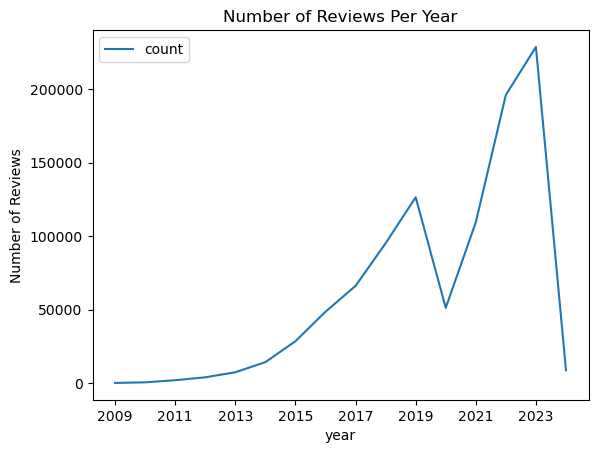

In [32]:
#D.1.6
# TO COMPLETE
q_yearinfo = """
 select CAST(EXTRACT (year FROM datetime) AS varchar(4)) AS Year, COUNT(*)
 FROM reviews
 GROUP BY Year
 ORDER BY Year
"""
with db_eng.connect() as conn:
    df = pd.read_sql(q_yearinfo, conn)
    #result = conn.execute(sql_text(q_yearinfo))
    #pprint.pp(result.all())

#df = pd.DataFrame(result.fetchall())
print(df)
df.plot(x="year", y="count")
plt.title("Number of Reviews Per Year")
plt.ylabel("Number of Reviews")
plt.show()

In [ ]:
##STEP 3B
# TO COMPLETE

In [ ]:
##STEP 3C
#TO COMPLETE